# SPML lab session: Graph Convolutional Networks
By Enrico Grimaldi - enrico.grimaldi@uniroma1.it

# Environment setup

- If you don't know anything about [Pytorch](https://github.com/pytorch/pytorch), I would recommend [this zero-to-hero tutorial](https://www.youtube.com/watch?v=Z_ikDlimN6A&t=2570s). This framework is fundamental for implementing deep learning architectures (generally preferred to [Tensorflow](https://github.com/tensorflow/tensorflow) in research).
- Once you have acquired some knowledge by practice, I recommend implementing more complex projects using [Lightning](https://github.com/Lightning-AI/pytorch-lightning), which wraps and organises PyTorch code to decouple research from engineering, making deep learning experiments easier to read and reproduce.
- Today we are going to play with [Pytorch_geometric](https://github.com/pyg-team/pytorch_geometric), a library for facilitate the implementation of Graph and Geometric DL models in pytorch.
- Geometric Deep Learning (advanced) reference: [Geometric Deep Learning book](https://arxiv.org/abs/2104.13478) [1]

In [1]:
! pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.9 MB/s eta 0:00:00


In [2]:
import os.path as osp
import time
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.logging import init_wandb, log

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Background in GSP

## Graphs


- A graph is a widely used mathematical structure designed to represent **pairwise interactions** between entities and serves as a fundamental example of topological space.
- It consists of a set of *nodes*, $\mathrm{V}$, and *edges*, $\mathrm{E}$ $\implies$ getting a graph $\mathrm{G(V,E)}$
- It can be of two types:
	- **directed**, if each edge $(i,j) \in \mathrm{E}$ has an associated direction
	- **undirected**, otherwise

> **Example of directed graph**
> In this case the graph $\mathrm{G(V,E)}$ is defined by:
> - $\mathrm{V}=\{0,1,2,3,4\}$
> - $\mathrm{E}=\{(0,1), (0,2), (1,2), (1,4), (2,3), (3,4)\}$

Nodes of the graph:  [0, 1, 2, 3, 4]
Edges of the graph:  [(0, 1), (0, 2), (1, 2), (1, 4), (2, 3), (3, 4)] 



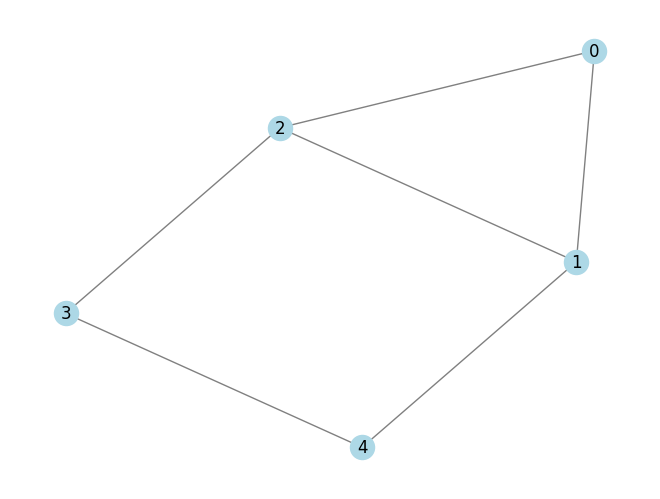

In [ ]:
# Create an empty graph
G = nx.Graph()

# Add nodes (vertices)
G.add_nodes_from(range(5))  # 5 nodes: 0, 1, 2, 3, 4
# # Add edges
G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 4), (2, 3), (3, 4)])

# Print nodes and edges
print("Nodes of the graph: ", G.nodes())
print("Edges of the graph: ", G.edges(), "\n")

# Draw the graph
nx.draw_kamada_kawai(G, with_labels=True, node_color="lightblue", edge_color="gray")
plt.show()

## Graph Algebraic Operators

Consider a Graph $\mathrm{G(V,E)}$, where:
- $V=|\mathrm{V|}$ $\implies$ number of nodes
- $E = |\mathrm{E}|$ $\implies$ number of edges

The graph is a basic topological domain, and its structure can be fully represented by its corresponding algebraic operators.
In practice each algebraic operator consists of a matrix encoding information about the graph itself, e.g.:
- adjacency (node-node) relation $\implies$ adjacency matrix
- boundary/incidence (node-edge) relation $\implies$ incidence matrix

### Adjacency Matrix

Is the matrix $A \in \mathbb{R}^{V \times V}$ that encodes the adjacency relations between the nodes of a graph, i.e.:
$$
\mathbf{A}[i,j] = a_{ij}=
    \begin{cases}
        1 \space\space\space &,(i,j) \in \mathrm{E} \\
        0 &, \textit{othw}
    \end{cases}
$$
**Properties**:
- $\mathbf{A}^k[i,j]$ $\implies$ number of paths of length $k$ from node $i$ to node $j$
- $\mathbf{A}^k[i,i]$ $\implies$ number of loops of length $k$ on node $i$
- $\operatorname{Tr}(\mathbf{A}^k)$ $\implies$ number of loops of length $k$ in the whole graph
- $\frac{\operatorname{Tr}(\mathbf{A}^3)}{6}$ $\implies$ number of triangles in the graph
- $d_i=\sum_j \mathbf{A}[i,j]$ $\implies$ degree of node $i$


If the graph is a **weighted graph**, i.e. a weight $w_{ij}$ is assigned to each edge $(i,j) \in \mathrm{E}$, we can define the **Weighted Adjacency Matrix** as $W \in \mathbb{R}^{V \times V}$ s.t.:
$$ \mathbf{A}[i,j] = \begin{cases} w_{ij} \space\space\space &,(i,j) \in \mathrm{E} \\ 0 &, \textit{othw} \end{cases} $$

### Degree Matrix

The **degree** of a node $i$ is the number of edges with an end in $i$.

> **Node degree for directed graphs**
>In directed graphs we have to differentiate between:
>- **indegree** $\implies$ number of edges having $i$ as head
>- **outdegree** $\implies$ number of edges having $i$ as tail

Is the diagonal matrix $\mathbf{D}=\operatorname{diag}(d_{1},\dots, d_{V}) \in \mathbb{R}^{V \times V}$ indicating the degree of each node in the graph, i.e.:
$$
d_i=\sum_j a_{ij} \quad \forall i \in \mathrm{V}
$$
### Incidence Matrix

Is the matrix $\mathbf{B} \in \mathbb{R}^{V \times E}$ relating the nodes and the edges of a graph.
- For directed graphs (*oriented incidence matrix*):
$$
\mathbf{B}[i,j] = b_{i,j} = \begin{cases}
1 \;, \text{node} \; i \; \text{is the tail of edge} \; (i,j) \\
-1 \;, \text{node} \; i \; \text{is the head of edge} \; (i,j)  \\
0 \;, \text{otherwise}
\end{cases}
$$

- For undirected graphs:  
$$
\mathbf{B}[i,j] = b_{i,j} = \begin{cases}
1 \;, \text{if} \; (i,j) \in \mathrm{E}\\
0 \;, \text{otherwise}
\end{cases}
$$

### Laplacian Matrix

Is the matrix $\mathbf{L} \in \mathbb{R}^{V \times V}$ given by:
$$
\mathbf{L}[i,j] = \begin{cases}
d_{i} \;, \text{if} \; i=j \\
-1 \;, \text{if} \; i\neq j \\
0 \;, \text{otherwise}
\end{cases}
$$
In other words:
$$
\mathbf{L} = \mathbf{D - A}
$$
or also:
$$
\mathbf{L=BB^T}
$$
**Properties**:
The main properties of the Laplacian matrix are very important for a number of tasks in Graph Signal Processing, i.e. when dealing with *Graph Signal]*.
1. $\mathbf{L}$ is **symmetric** and **semi-definite** (**when the graph is undirected!**)
2. The smallest eigenvalue of $\mathbf{L}$ is $\lambda_{1}=0$ with corresponding eigenvector $\mathbf{1} \in \mathbb{R}^V$
3. $\mathbf{L}$ has eigenvalues $\lambda_{1} \leq \lambda_{2} \leq \dots \leq \lambda_{V}$
4. If $\mathrm{G}$ is a weighted undirected graph s.t. $w_{ij} \in \mathbb{R_{+}}$, then the multiplicity of the smallest eigenvector $\lambda_{1}$, is $\mu_{1}=k$, and represents the number of connected components of the graph $\mathrm{G}$
	1. $\implies$ $\operatorname{Rank(\mathbf{L})=V-k}$
	2. $\implies$ given the k connected components $A_{1},\dots, A_{k}$, the eigenspace of $\lambda_{1}$ is spanned by the connected components indicator vectors $\mathbb{I}_{A_{1}},\dots,\mathbb{I}_{A_{k}}$

The Laplacian matrix, thanks to its just mentioned properties, is a great tool to perform *Spectral Clustering*, *Graph Fourier Transform* and to build *Graph FIlters*. In particular it can be used to evaluate the so-called **Disagreement** of a graph signal $\mathbf{x} \in \mathbb{R}^V$, i.e.: $$ \mathbf{x^{T}Lx}= \frac{1}{2} \sum_{i,j} a_{ij}(x_{i}-x_{j})^2$$



Adjacency Matrix:
 [[0 1 1 0 0]
 [1 0 1 0 1]
 [1 1 0 1 0]
 [0 0 1 0 1]
 [0 1 0 1 0]] 

Laplacian Matrix:
 [[ 2 -1 -1  0  0]
 [-1  3 -1  0 -1]
 [-1 -1  3 -1  0]
 [ 0  0 -1  2 -1]
 [ 0 -1  0 -1  2]] 



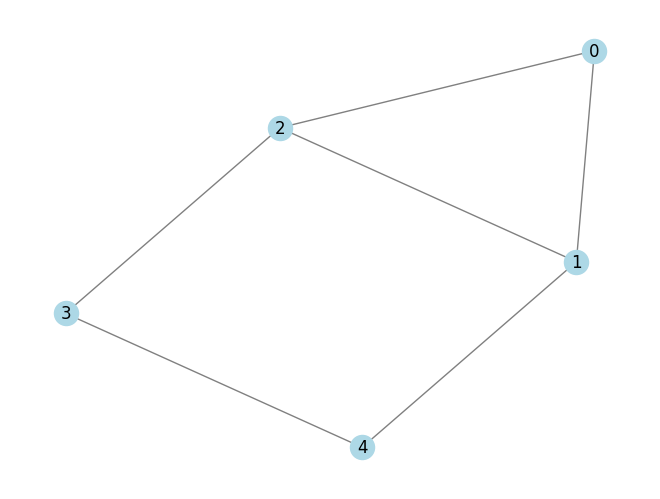

In [ ]:
# Adjacency matrix
A = nx.adjacency_matrix(G)
print("Adjacency Matrix:\n", A.todense(), "\n")

# Laplacian matrix
L = nx.laplacian_matrix(G)
print("Laplacian Matrix:\n", L.todense(), "\n")

nx.draw_kamada_kawai(G, with_labels=True, node_color="lightblue", edge_color="gray")
plt.show()

## Graph Signal Processing

### Graph Signal

A Graph Signal is a function defined over the nodes of a Graph $\mathrm{G(V,E)}$, i.e. $\mathbf{x}:\mathrm{V} \rightarrow \mathbb{R}$. A graph signal can be represented by a vector $\mathbf{x} \in \mathbb{R}^V$, where $V$ is the cardinality of the set of nodes $\mathrm{V}$.

Refer to [Ortega, A. et al. (2018). Graph signal processing: Overview, challenges, and applications.](https://arxiv.org/abs/1712.00468) for further exploring the field of Graph Signal Processing [2].

### Graph Shift Operator (GSO)

The GSO is linear map $\mathbf{S}:\mathbb{R}^V\rightarrow \mathbb{R}^V$, that causes the shift of the *Graph Signal* $\mathbf{x}\in \mathbb{R}^V$, i.e. the signal diffuses over the nodes of the graph according to the diffusion operator $\mathbf{S}$.
The operator itself, $\mathbf{S} \in R^{V \times V}$, indeed represents the structure of the related Graph and is such that:
$$
\mathbf{S}[i,j]=0 \iff (i,j) \not\in \mathrm{E}, i \neq j
$$
The value of the shifted signal at node $i$ is given by:
$$
[\mathbf{S}\mathbf{x}]_{i}= \sum_{j=1}^V \mathbf{S}[i,j]\mathbf{x}_j=\sum_{j \in \{\mathrm{N_{i}}\cup i\}} \mathbf{S}[i,j] \mathbf{x}_j
$$

> **Examples**:
>- Choosing the Adjacency matrix $\mathbf{A}$ as GSO $\implies$ $\mathbf{A}\mathbf{x}$ $\implies$ one-step propagation
>- Choosing the Laplacian matrix $\mathbf{L}$ as GSO $\implies$ $\mathbf{L}\mathbf{x}$ $\implies$ the shifted signal is the result of a difference with the values of the signal at neighbouring nodes

### Graph FIlter

**Classical Discrete Filters**: information processing architectures/procedures which store and manipulate signals. They are often used to preserve only relevant content of the signal in input, based on the task at hand.

> **Filtering in science**
>- filtering in Signal Processing $\implies$ preserving specific spectral content of the input
>- filtering in Machine Learning $\implies$ extract relevant patterns from / induce some relational bias in learning architectures.
>	- example 1: **PCA** $\iff$ filter in the correlation matrix, only part of data contributing to the **directions of largest variance** are preserved
>	- example 2: **CNN** $\iff$ use an operator that exploits the structural invariance of the input

**Graph Filters**: Information processing architectures tailored to graph-structured data (generalization of classical filters).

The concept of **Convolutional Graph Filter** is strictly related to the notion of **Graph Shift Operator (GSO)**. Given a graph signal $\mathbf{x} \in \mathbb{R}^V$, and a Graph Shift Operator $\mathbf{S}$, a $K$-th order Convolutional Graph Filter can be equivalently described as:
- a linear mapping $\mathrm{H}:\mathbb{R}^V \rightarrow \mathbb{R}^V$
- a *linear combination of $K$ shifted signals*
- a convolution with a *polynomial kernel*
- (in practice) a multiplication with a polynomial function of the shift operator $S$
$$
\mathrm{H}(\mathbf{x})= \sum_{k=0}^K h_{k} \mathbf{S}^k \mathbf{x}
$$

> **Notice**:
>- the polynomial filtering matrix $\mathrm{H}(\mathbf{S})=\sum_{k=0}^K h_{k} \mathbf{S}^k$ is dependent on the choice of the GSO
>- each parameter $h_{k}$ weights how much importance I want to give to the *$k$-th order neighbourhood* in the sum
>- output of a filtering operation is a linear combination of signal values located at most up to $k$-hops away

**Properties**:
1. **Linearity**: given two input signals $\mathbf{x}_{1}$, $\mathbf{x}_{2} \in \mathbb{R}^V$ $$ \alpha \mathrm{H}(\mathbf{S})\mathbf{x_{1}} +\beta \mathrm{H}(\mathbf{S})\mathbf{x_{2}} = \mathrm{H}(\mathbf{S}) (\alpha \mathbf{x_{1}}+\beta \mathbf{x_{2}}) $$
2. **Shift Invariance**: given two graph conv. filter $\mathrm{H_{1}}(\mathbf{S})$, $\mathrm{H_{1}}(\mathbf{S})$, we can switch them without changing the result $$\mathrm{H_{1}}(\mathbf{S}) \cdot \mathrm{H_{2}}(\mathbf{S}) \cdot \mathbf{x}= \mathrm{H_{2}}(\mathbf{S}) \cdot \mathrm{H_{1}}(\mathbf{S}) \cdot \mathbf{x} $$
3. **Permutation Equivariance**:
	1. given the set of permutation matrices $\mathbb{P}=\{\mathbf{P} \in \{0,1\}^{V \times V}| \mathbf{P} \mathbf{1}=\mathbf{1}, \mathbf{P}^T  \mathbf{1}=\mathbf{1}\}$
	2. given the GSO for the permuted graph $\mathbf{S'= P^TSP}$
	3. given the permuted signal $\mathbf{x}'= \mathbf{P}^T\mathbf{x}$
	we have that:
	$$\mathrm{H}(\mathbf{S}')\mathbf{x}= \mathbf{P}^T\mathrm{H}(\mathbf{S})\mathbf{x}$$
4. **Parameter Sharing**: all nodes share the convolution parameters $\mathbf{h}=[h_{1},\dots, h_{k}]^T$
5. **Locality**: shift $\mathbf{z}^k = \mathbf{S}^k\mathbf{x}$ can be evaluated recursively, i.e.: $$\mathbf{z}^k = \mathbf{S}(\mathbf{S}^{k-1}\mathbf{x})= \mathbf{S} \mathbf{z}^{k-1}$$
6. **Linear Complexity**: can be proved that the graph filtering operation can be applied in $\mathrm{O}(kV + kE)$


> **Classical VS Graph Filters**
- Similarities:
	- linearity
	- shift invariance
	- parametric function of the input
- Differences:
	- equivariant to the permutation in the support
	- enjoy a distributed implementation
	- can assume different generalization forms (e.g. node or edge varying)

# Deep Learning on Graphs

## Graph Perceptron

**Assumptions**:



- **Graph domain** $\mathrm{G(V,E)}$
- **Training set** of observation pairs $T=\{ (\mathbf{x}, \mathbf{y})|\mathbf{x} \in \mathbb{R}^V, \mathbf{y} \in \mathbb{R}^V\}$ both defined over the nodes of the graph
	- $\mathbf{x}$ $\rightarrow$ input graph signal
	- $\mathbf{y}$ $\rightarrow$ output (target) signal, after processing over the graph
-  **Model** consisting in a function $\phi \in \mathrm{C}$, where $\mathrm{C}$ is a certain **class of functions**
-  **Predicted output** signal $\widehat{\mathbf{y}}=\phi(\mathbf{x})$
- **Loss** function $l(\mathbf{\widehat{y}}, \mathbf{y})$

**Learning Goal**:
Empirical Risk Minimization with graph data $\iff$ find the function $\phi^*$ s.t.:

$$
\phi^*=\underset{\phi}{\arg\min} \sum_{(\mathbf{x},\mathbf{y})\in T} l(\phi(\mathbf{x}), \mathbf{y})
$$
**Idea**:
1. Since $\mathbf{x}$ are graph signals, we want to exploit the geometry under the data to induce some **relational bias** in the model.

2. We can use our prior knowledge about the graph such as the **Graph Shift Operator** $\mathbf{S}$

3. We bias our model by restricting the class of functions in which we search our solution $\phi^*$ , to the set of **Graph Filter** functions (we like the properties of this class of functions for graph signals), i.e.: $$\phi(\mathbf{x})= \sum_{k=0}^K h_{k} \mathbf{S}^k \mathbf{x}= \phi(\mathbf{x},\mathbf{S},\mathbf{h})$$
4. Now we map the problem from finding the best function $\phi^*$ to finding the best parameters $\mathbf{h}^*$ that describe the desired function, i.e.:

$$
\mathbf{h}^*=\underset{\mathbf{h}}{\arg\min} \sum_{(\mathbf{x},\mathbf{y})\in T} l(\phi(\mathbf{x}, \mathbf{S}, \mathbf{h}), \mathbf{y})
$$

5. Finally we simply add some non-linearity $\sigma(\cdot)$ to the function $\phi(\cdot)$, gaining more expressive power through a larger class of functions, i.e.:

$$
\mathbf{h}^*=\underset{\mathbf{h}}{\arg\min} \sum_{(\mathbf{x},\mathbf{y})\in T} l(\sigma(\phi(\mathbf{x}, \mathbf{S}, \mathbf{h})), \mathbf{y})
$$

6. The predicted value is $\widehat{\mathbf{y}} = \sigma(\phi(\mathbf{x}, S, \mathbf{h}))$

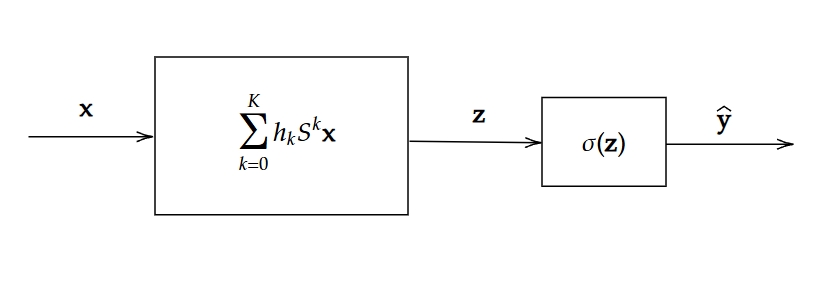

## MIMO Graph Neural Networks



A GNN, or better, a **Multiple-output multiple-input (MIMO) GNN**, generalizes the idea of **Graph Perceptron** by:
1. stacking $L$ different Graph Perceptron layers
2. each Graph Signal observation is given by a matric $\mathbf{X}\in \mathbb{R}^{V \times F}$, where:
	- $V$ is the number of nodes of the graph on which data is defined
	- $F$ is the number of features at each node (now we have vectors, no more single values, for each node in the graph)

1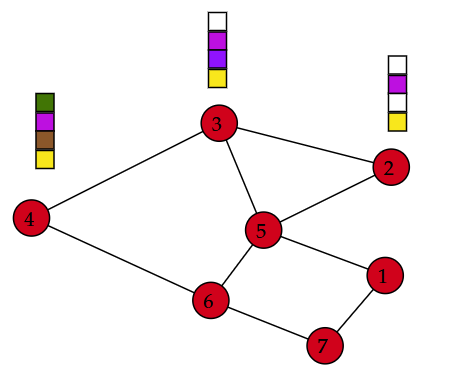

Thus, for an $L$-layers MIMO GNN we get that:
$$
\begin{cases}
\mathbf{Z}^{(1)}= \sum_{k=0}^K \mathbf{S}^k \mathbf{X}^{(1)}H_{k}^{(1)} \\
\mathbf{X}^{(1)}=\sigma_{1}(\mathbf{Z}^{(1)}) \\
\vdots \\
\mathbf{Z}^{(l)}= \sum_{k=0}^K \mathbf{S}^k \mathbf{X}^{(l-1)}H_{k}^{(l)} \\
\mathbf{X}^{(l)}=\sigma_{l}(\mathbf{Z}^{(l)}) \\ \\
\vdots \\
\mathbf{Z}^{(L)}= \sum_{k=0}^K \mathbf{S}^k \mathbf{X}^{(L-1)}H_{k}^{(L)} \\
\mathbf{X}^{(L)}=\sigma_{L}(\mathbf{Z}^{(L)}) \\
\end{cases}
$$
where $\forall l=1,\dots,L$:
- $\mathbf{Z}^{(l)}\in \mathbb{R}^{V \times G_{l}}$, $l = 1,\dots,L$ $\rightarrow$ the $l$-th layer activations
- $H_{k}^{(l)} \in \mathbb{R}^{G_{l-1} \times G_{l}}$ for $k=0,\dots,K$ $\rightarrow$ the $l$-th layer parameters
- $\sigma_{l}(\cdot)$ $\rightarrow$ the $l$-th layer element-wise activation function
- $G_{l}$ $\rightarrow$ the $l$-th layer feature dimensionality (e.g. $G_{0}=V$, $G_{1}=F$)

The **hidden representation** at a specific layer $l$ for node $i$ is given by this local update:
$$\mathbf{x}_i^{(l)} = \sigma_l\Big(\sum_{k=0}^K \sum_{j} \mathbf{S}^k[i,j]\, \mathbf{H}_k^{(l)} \, \mathbf{x}_j \Big)$$

> **TIP**: GNN as a generalization of MLP
>
> The introduced MIMO GNN can be reduced to a simple **Multilayer Perceptron** if:
> 1. we set the filter order $K=1$ for each layer
> 2. we don't use any prior knowledge to restrict the class of functions $\mathrm{C}$ and simply set $\mathbf{S}=\mathbf{I}$


This type of graph nueral networks are also referred to as **Graph Convolutional Networks (GCN)**, reflecting the fact the they use the graph convolutional layer (i.e. graph conv. filters).


# Exercise 1: Semi-supervised Learning for Nodes Classification

#### **Dataset**:

The **Cora** dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

This dataset is exactly aimed for semi-supervised learning for graph-structures data, presenting a way smaller number of training (labeled) nodes.

In [ ]:
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid("../data", "Cora", transform=T.NormalizeFeatures())
data = dataset[0].to(device)
# Take a dense version of the adjacency matrix
A = to_dense_adj(data.edge_index)[0].to(device)
data

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [5]:
stats = {
    "Dataset Name": dataset.name,
    "Number of Features": data.num_node_features,
    "Number of Classes": dataset.num_classes,
    "Number of Nodes": data.num_nodes,
    "Number of Edges": data.num_edges,
    "Number of Training Nodes": data.train_mask.sum().item(),
    "Number of Validation Nodes": data.val_mask.sum().item(),
    "Number of Test Nodes": data.test_mask.sum().item(),
    "Is Directed": data.is_directed(),
}

# Visualize stats
pd.DataFrame(stats.items(), columns=["Statistic", "Value"])

,Statistic,Value
0,Dataset Name,Cora
1,Number of Features,1433
2,Number of Classes,7
3,Number of Nodes,2708
4,Number of Edges,10556
5,Number of Training Nodes,140
6,Number of Validation Nodes,500
7,Number of Test Nodes,1000
8,Is Directed,False


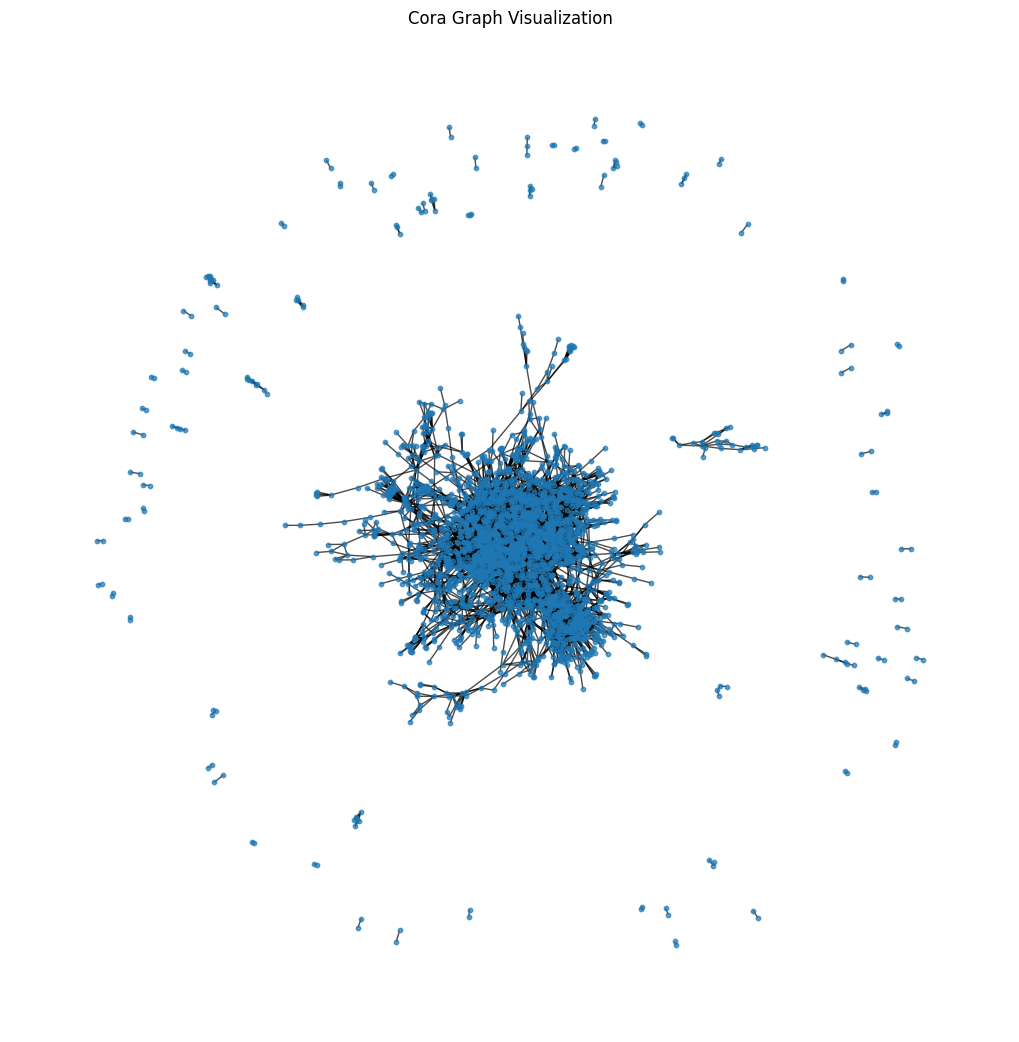

In [ ]:
# THIS CELL IS ONLY FOR VISUALIZATION PURPOSES!
# YOU DON'T NEED TO RUN THIS CELL... IT WOULD TAKE SOME MINUTES TO PLOT THE GRAPH

# edge_index = data.edge_index
# num_nodes = data.num_nodes
# adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.int)

# for src, dst in edge_index.t():
#     adj_matrix[src, dst] = 1

# cora_graph = nx.from_numpy_array(adj_matrix.numpy())
# plt.figure(figsize=(10, 10))
# pos = nx.spring_layout(cora_graph)
# nx.draw(cora_graph, pos, node_size=10, with_labels=False, alpha=0.7)
# plt.title("Cora Graph Visualization")
# plt.show()

#### **Setup:**

- **Problem**:
Classification of nodes in a graph, where labels are only avaiable for a small subset of nodes (semi-supervised learning task)

- **Design choices for our basic GCN model**:
  1. Use Graph Convolutional Layers based on 1-st order Graph Filters (i.e. $K=1$)
  2. Use the Adjacency matrix $A$ as Graph Shift Operator inside the GConv layers
  3. Setup a model with only two GConv Layers

- **GCN Architecture**
$$
\mathbf{Z} = f(\mathbf{X},\mathbf{A}) = \text{softmax}(\mathbf{A} \cdot \text{ReLU}(\mathbf{AX}\mathbf{H}_0)\mathbf{H}_1)
$$

**Why do we call it Semi-supervised Learning?**
- Only a small fraction of nodes (the training set) are labeled and used during training
- The model learns representations for all nodes (labeled and unlabeled) by propagating information (node features) across the graph structure, and generalizing to unlabeled nodes based on their connections to labeled nodes
- During training, the labels of validation and test nodes are not used

Refer to [Kipf, T. N. (2016). Semi-supervised classification with graph convolutional networks](https://export.arxiv.org/abs/1609.02907) for further information [3].

In [ ]:
import torch
import torch.nn as nn
from torch import Tensor
from typing import Callable, Optional


class GCNLayer(nn.Module):
    """
    Single graph convolutional layer.

    This layer applies a linear transformation to the node features and then
    propagates them through the (normalized) graph shift operator S.

    Parameters
    ----------
    in_features : int
        Number of input features per node.
    out_features : int
        Number of output features per node.
    activation : callable, optional
        Optional activation function to apply after the linear transformation.
        It must accept and return a `torch.Tensor`. If None, no activation is
        applied inside the layer (default: None).
    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        activation: Optional[Callable[[Tensor], Tensor]] = None,
    ) -> None:
        # TODO: initialize the layer parameters and hyperparamters

    def init_parameters(self) -> None:
        """
        Initialize layer parameters with Xavier uniform initialization.

        This is the method described in:
        *Glorot, X., & Bengio, Y. (2010). "Understanding the difficulty of
        training deep feedforward neural networks".*

        Returns
        -------
        None
        """
        # TODO: Fills the parameters Tensor with values according to the method
        # described in Understanding the difficulty of training deep feedforward
        # neural networks - Glorot, X. & Bengio, Y. (2010), using a uniform distribution.


    def forward(self, x: Tensor, S: Tensor) -> Tensor:
        """
        Apply the graph convolution.

        The operation is:
            S @ x @ W
        where:
            - S is the (normalized) graph shift / adjacency-like matrix,
            - x are the node features,
            - W are the learnable weights.

        Parameters
        ----------
        x : torch.Tensor
            Node feature matrix of shape ``(N, in_features)``, where
            ``N`` is the number of nodes.
        S : torch.Tensor
            Graph shift operator of shape ``(N, N)``. Typically a (normalized)
            adjacency or Laplacian-derived matrix.

        Returns
        -------
        torch.Tensor
            Output node features of shape ``(N, out_features)``.
        """
        # TODO: Apply the forward step of the GCN layer using the input graph
        # signals and GSO

        return None



class GCNModel(nn.Module):
    """
    Two-layer Graph Convolutional Network (GCN).

    This model consists of:
        - One hidden graph convolutional layer with ReLU activation.
        - One output graph convolutional layer without activation.

    Parameters
    ----------
    in_channels : int
        Number of input features per node.
    hidden_channels : int
        Number of hidden units in the first GCN layer.
    out_channels : int
        Number of output classes (for node classification) or features.
    """

    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
    ) -> None:
        super().__init__()
        # TODO

    def forward(self, x: Tensor, S: Tensor) -> Tensor:
        """
        Forward pass of the GCN model.

        Parameters
        ----------
        x : torch.Tensor
            Input node feature matrix of shape ``(N, in_channels)``.
        S : torch.Tensor
            Graph shift operator of shape ``(N, N)``.

        Returns
        -------
        torch.Tensor
            Output logits (unnormalized scores) of shape
            ``(N, out_channels)``.
        """
        # TODO: Return the final logits (you don't have to apply the softmax since
        # the CrossEntropy loss that we are going to use later takes logits and
        # returns the correct normalized final output.



A quite cringe but still pretty useful resource to memorize the training and test loops in Pytorch: [The Unofficial PyTorch Optimization Loop Song](https://www.youtube.com/watch?v=Nutpusq_AFw)

In [ ]:
# 1. Some hyperparams
hidden_channels = 8
lr = 0.01
epochs = 50

# 2. Init GCN model
model = GCNModel(
    in_channels=dataset.num_features,
    hidden_channels=hidden_channels,
    out_channels=dataset.num_classes,
).to(device)  # remember to load the model on the available GPU

# 3. Init the optimizer (Adam) with model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
from torch.optim import Optimizer
from typing import List


def train(
    model: torch.nn.Module,
    optimizer: Optimizer,
    x: Tensor,
    y: Tensor,
    S: Tensor,
    train_mask: Tensor,
) -> float:
    """
    Train the GCN model on the nodes specified by the training mask.

    Parameters
    ----------
    model : torch.nn.Module
        The GCN model to train.
    optimizer : torch.optim.Optimizer
        Optimizer used for updating model parameters.
    x : torch.Tensor
        Node features of shape ``(N, in_channels)``.
    y : torch.Tensor
        Ground-truth labels of shape ``(N,)``.
    S : torch.Tensor
        Graph shift operator of shape ``(N, N)``.
    train_mask : torch.Tensor
        Boolean mask specifying the nodes used for training.

    Returns
    -------
    float
        The training loss value.
    """

    # 0. Turn on model training mode (To inform layers which are designed to behave differently during training and evaluation, e.g. Dropout.)
    model.train()
    # 1. Forward pass
    out = model(x, S)
    # 2. Calculate the loss
    loss = F.cross_entropy(out[train_mask], y[train_mask])
    # 3. Clear the optimizer gradients
    optimizer.zero_grad()
    # 4. Perform backpropagation to compute gradients
    loss.backward()
    # 5. Update model prameters with the just computed gradients
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(
    model: torch.nn.Module,
    data,
    S: Tensor,
) -> List[float]:
    """
    Evaluate the GCN model on training, validation, and test sets.

    Parameters
    ----------
    model : torch.nn.Module
        The trained GCN model.
    data : object
        Data object containing:
            - `x`: node features,
            - `y`: ground-truth labels,
            - `train_mask`, `val_mask`, `test_mask`: boolean masks.
    S : torch.Tensor
        Graph shift operator of shape ``(N, N)``.

    Returns
    -------
    list of float
        List containing accuracies for the training, validation,
        and test sets, in this order.
    """
    # 0. Turn on model (inference) evaluation mode
    model.eval()
    # 1. Forward pass
    pred = model(data.x, S).argmax(dim=-1)  # Get predictions
    # 2. Calculate performance metric (accuracy) for training, validation, and test sets
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum().item()
        total = int(mask.sum())
        accs.append(correct / total)
    return accs


In [ ]:
# Initialize variables to keep track of the best validation accuracy and test accuracy
best_val_acc = test_acc = 0
times = []  # List to store time taken per epoch

# Training loop
for epoch in range(1, epochs + 1):
    start = time.time()  # Start timer for epoch
    loss = train(
        model=model,
        optimizer=optimizer,
        x=data.x,
        y=data.y,
        S=A,
        train_mask=data.train_mask,
    )  # Train the model
    train_acc, val_acc, tmp_test_acc = test(
        model=model, data=data, S=A
    )  # Test the model

    # Update the best validation accuracy and corresponding test accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc

    # Log training progress
    log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)

    # Record the time taken for epoch
    times.append(time.time() - start)

# Print the median time per epoch
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

/tmp/ipython-input-2435596891.py:49: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return float(loss)


Epoch: 001, Loss: 1.9566, Train: 0.3286, Val: 0.2460, Test: 0.2450
Epoch: 002, Loss: 1.7669, Train: 0.4643, Val: 0.3160, Test: 0.3110
Epoch: 003, Loss: 1.6335, Train: 0.6214, Val: 0.4700, Test: 0.4420
Epoch: 004, Loss: 1.5124, Train: 0.7357, Val: 0.5700, Test: 0.5600
Epoch: 005, Loss: 1.3978, Train: 0.7786, Val: 0.6280, Test: 0.6030
Epoch: 006, Loss: 1.2882, Train: 0.8143, Val: 0.6460, Test: 0.6120
Epoch: 007, Loss: 1.1967, Train: 0.8357, Val: 0.6760, Test: 0.6310
Epoch: 008, Loss: 1.1179, Train: 0.8857, Val: 0.6940, Test: 0.6560
Epoch: 009, Loss: 1.0437, Train: 0.9214, Val: 0.7060, Test: 0.6720
Epoch: 010, Loss: 0.9737, Train: 0.9286, Val: 0.7320, Test: 0.6920
Epoch: 011, Loss: 0.9053, Train: 0.9429, Val: 0.7440, Test: 0.7190
Epoch: 012, Loss: 0.8395, Train: 0.9500, Val: 0.7580, Test: 0.7340
Epoch: 013, Loss: 0.7786, Train: 0.9643, Val: 0.7620, Test: 0.7390
Epoch: 014, Loss: 0.7250, Train: 0.9643, Val: 0.7700, Test: 0.7440
Epoch: 015, Loss: 0.6759, Train: 0.9643, Val: 0.7760, Test: 0.

Epoch: 050, Loss: 0.2035, Train: 1.0000, Val: 0.7460, Test: 0.7400

#### GCN with `TAGConv` from torch_geometric

Advantages of using `TAGConv` and `torch_geometric` functions and classes:
1. faster and cleaner implementation
2. easier to handle transformations of the Graph Shift Operator

**Notice**: when working with the Adjacency matrix as GSO is better to:
- add self-loops to parameterize the information on the current node (otherwise we would only diffusing information on the neighboring nodes)
- apply some sort of normalization to the matrix (e.g. symmetic normalization)

In Pytorch Geometric all the graph models are implemented according to unifying notation provided by the **Message-Passing Framework**. If you are interested in a more rigorous and complete introduction to this topic, I would recommend the following resource:
[Graph Representation Learning book](https://www.cs.mcgill.ca/~wlh/grl_book/files/GRL_Book.pdf) [4].

In [17]:
from torch_geometric.nn import TAGConv
from torch_geometric.utils import add_self_loops


class GCNModel(torch.nn.Module):
    """
    Two-layer Topology Adaptive Graph Convolutional Network (TAGCN).

    This model applies:
    - Two TAGConv layers using K-th order polynomial filters.
    - Automatic addition of self-loops to the input graph structure.
    - ReLU activation applied after the first convolutional layer.

    Parameters
    ----------
    in_channels : int
        Number of input features per node.
    hidden_channels : int
        Number of hidden units in the first TAGConv layer.
    out_channels : int
        Number of output classes or features.
    filter_order : int, optional
        Polynomial filter order (K) used by TAGConv layers. Default is 3.
    """

    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        filter_order: int = 3,
    ) -> None:
        super().__init__()

        self.conv1 = TAGConv(
            in_channels,
            hidden_channels,
            K=filter_order,
            normalize=True,
            bias=False,
        )

        self.conv2 = TAGConv(
            hidden_channels,
            out_channels,
            K=filter_order,
            normalize=True,
            bias=False,
        )

    def forward(
        self,
        x: Tensor,
        edge_index: Tensor,
        edge_weight: Optional[Tensor] = None,
    ) -> Tensor:
        """
        Forward pass of the TAGCN model.

        Parameters
        ----------
        x : torch.Tensor
            Node feature matrix of shape ``(N, in_channels)``.
        edge_index : torch.Tensor
            Graph connectivity in COO format with shape ``(2, E)``.
        edge_weight : torch.Tensor, optional
            Optional edge weights of shape ``(E,)``. If None, weights are assumed
            uniform.

        Returns
        -------
        torch.Tensor
            Node-level outputs of shape ``(N, out_channels)``.
        """
        edge_index, edge_weight = add_self_loops(
            edge_index,
            edge_attr=edge_weight,
            fill_value=1.0,
        )

        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight)
        return x


In [18]:
hidden_channels = 8
lr = 0.01
epochs = 50

model = GCNModel(
    in_channels=dataset.num_features,
    hidden_channels=hidden_channels,
    out_channels=dataset.num_classes,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
best_val_acc = test_acc = 0
times = []

# Training loop
for epoch in range(1, epochs + 1):
    start = time.time()
    loss = train(
        model=model,
        optimizer=optimizer,
        x=data.x,
        y=data.y,
        S=data.edge_index,
        train_mask=data.train_mask,
    )
    train_acc, val_acc, tmp_test_acc = test(model=model, data=data, S=data.edge_index)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc

    log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)

    times.append(time.time() - start)

# Print the median time per epoch
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 001, Loss: 0.0819, Train: 1.0000, Val: 0.7420, Test: 0.7460
Epoch: 002, Loss: 0.0740, Train: 1.0000, Val: 0.7460, Test: 0.7460
Epoch: 003, Loss: 0.0669, Train: 1.0000, Val: 0.7460, Test: 0.7460
Epoch: 004, Loss: 0.0606, Train: 1.0000, Val: 0.7480, Test: 0.7510
Epoch: 005, Loss: 0.0550, Train: 1.0000, Val: 0.7460, Test: 0.7510
Epoch: 006, Loss: 0.0500, Train: 1.0000, Val: 0.7500, Test: 0.7520
Epoch: 007, Loss: 0.0456, Train: 1.0000, Val: 0.7520, Test: 0.7520
Epoch: 008, Loss: 0.0417, Train: 1.0000, Val: 0.7540, Test: 0.7560
Epoch: 009, Loss: 0.0383, Train: 1.0000, Val: 0.7500, Test: 0.7560
Epoch: 010, Loss: 0.0352, Train: 1.0000, Val: 0.7500, Test: 0.7560
Epoch: 011, Loss: 0.0325, Train: 1.0000, Val: 0.7480, Test: 0.7560
Epoch: 012, Loss: 0.0301, Train: 1.0000, Val: 0.7500, Test: 0.7560
Epoch: 013, Loss: 0.0279, Train: 1.0000, Val: 0.7500, Test: 0.7560
Epoch: 014, Loss: 0.0260, Train: 1.0000, Val: 0.7500, Test: 0.7560
Epoch: 015, Loss: 0.0243, Train: 1.0000, Val: 0.7500, Test: 0.

# Exercise 2: Graph Classification

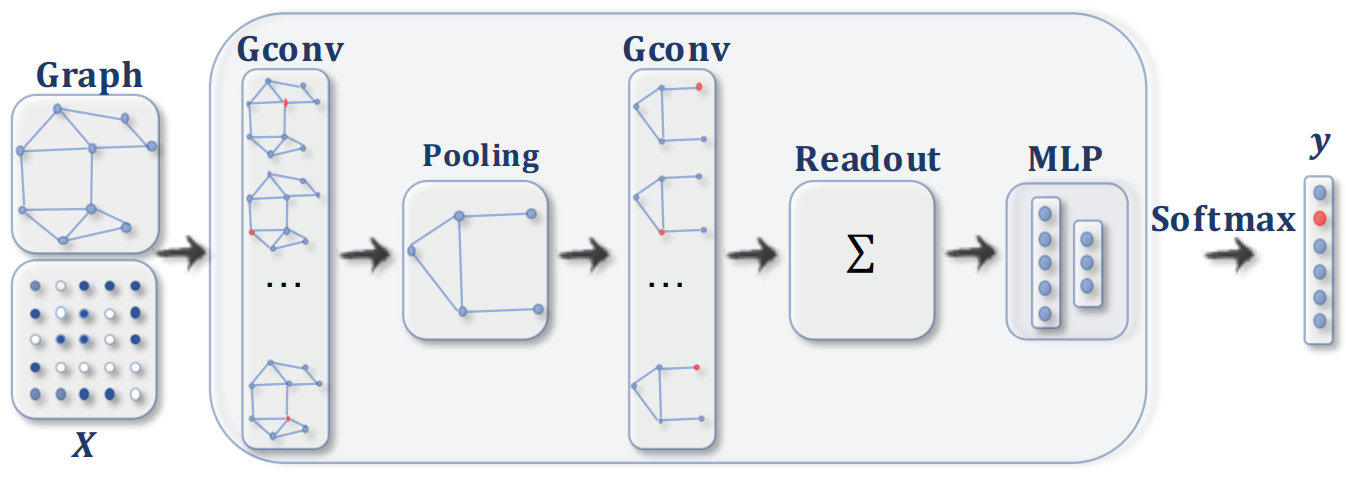

**Idea**:
- graph convolutional layers are responsible for exacting high-level node representations
- graph pooling layers play the role of downsampling, which coarsens each graph into a sub-structure each time
- A readout layer collapses node representations of each graph into a graph representation
- The MLP is responsible for the final decision-making process, effectively mapping the coarsened graph representations to output labels or scores for classification tasks.

Check [this survey on graph neural networks](https://ieeexplore.ieee.org/document/9046288) [4] for a complete overview of the topic.

**Dataset:**

***MUTAG*** is a collection of nitroaromatic compounds and the goal is to predict their mutagenicity on Salmonella typhimurium. Input graphs are used to represent chemical compounds, where vertices stand for atoms and are labeled by the atom type (represented by one-hot encoding), while edges between vertices represent bonds between the corresponding atoms. It includes 188 samples of chemical compounds with 7 discrete node labels.

Data ref: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/mutag_gin.py

In [ ]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset("../data", name="MUTAG").shuffle()
batch_size = 8
train_loader = DataLoader(dataset[:0.8], batch_size, shuffle=True)
test_loader = DataLoader(dataset[0.8:], batch_size)

Processing...
Done!


In [23]:
# Analyze the dataset
data_summary = {
    "Number of Nodes": [],
    "Number of Edges": [],
    "Label": [],
}

for idx, data in enumerate(dataset):
    num_nodes = data.num_nodes
    num_edges = data.num_edges
    label = data.y.item() if data.y is not None else None

    data_summary["Number of Nodes"].append(num_nodes)
    data_summary["Number of Edges"].append(num_edges)
    data_summary["Label"].append(label)

df = pd.DataFrame(data_summary)

# Display main features
print("Dataset Summary:")
print(f"Total Graphs: {len(dataset)}")
print(f"Number of labels: {dataset.num_classes}")
print(f"Number of node features: {dataset.num_features}", "\n")
df

Dataset Summary:
Total Graphs: 188
Number of labels: 2
Number of node features: 7 



,Number of Nodes,Number of Edges,Label
0,11,22,0
1,22,50,1
2,17,38,1
3,19,44,1
4,17,38,1
...,...,...,...
183,17,38,1
184,23,54,1
185,11,22,0
186,16,34,1


**Setup:**

Implement a **multi-layer GCN** for **graph classification** with the following requirements:

- Each GCN layer must use **filter order = 1** (you might use `GCNConv` from `torch_geometric.nn`) and be followed by a **ReLU** activation.
- Stack multiple GCN layers of your choice (hidden size and number of layers are up to you).
- After the last GCN layer, apply a **global readout** (`global_add_pool`, `mean`, or `max`) to obtain a graph-level embedding.
- Feed the graph embedding into a final **MLP classifier** that outputs the class logits.

In [ ]:
import torch
from torch import Tensor
from torch_geometric.nn import GCNConv, MLP, global_add_pool
from typing import List


class GCN(torch.nn.Module):
    """
    Multi-layer Graph Convolutional Network (GCN) followed by an MLP for
    graph-level classification.

    This model applies:
    - A stack of GCNConv layers with ReLU activation.
    - Global add pooling to obtain graph embeddings.
    - A final MLP for classification.

    Parameters
    ----------
    in_channels : int
        Number of input features per node.
    hidden_channels : int
        Number of hidden units in each GCN layer.
    out_channels : int
        Number of output classes or features.
    num_layers : int
        Number of GCN layers to apply.
    """

    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        num_layers: int,
    ) -> None:
        super().__init__()
        # TODO

    def forward(
        self,
        x: Tensor,
        edge_index: Tensor,
        batch: Tensor,
    ) -> Tensor:
        """
        Forward pass of the GCN model.

        Parameters
        ----------
        x : torch.Tensor
            Node features of shape ``(N, in_channels)``.
        edge_index : torch.Tensor
            Graph connectivity in COO format of shape ``(2, E)``.
        batch : torch.Tensor
            Batch vector assigning each node to a graph, of shape ``(N,)``.

        Returns
        -------
        torch.Tensor
            Graph-level outputs of shape ``(B, out_channels)``,
            where ``B`` is the number of graphs in the batch.
        """
        # TODO


In [27]:
epochs = 50
lr = 0.01
num_layers = 3

In [28]:
model = GCN(
    in_channels=dataset.num_features,
    hidden_channels=hidden_channels,
    out_channels=dataset.num_classes,
    num_layers=num_layers,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
times = []
for epoch in range(1, epochs + 1):
    start = time.time()
    loss = train(train_loader, model, optimizer, "cuda")
    train_acc = test(train_loader, model, "cuda")
    test_acc = test(test_loader, model)
    log(Epoch=epoch, Loss=loss, Train=train_acc, Test=test_acc)
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 001, Loss: 0.5369, Train: 0.7000, Test: 0.6842
Epoch: 002, Loss: 0.5109, Train: 0.7733, Test: 0.8684
Epoch: 003, Loss: 0.5138, Train: 0.7400, Test: 0.7632
Epoch: 004, Loss: 0.5440, Train: 0.7467, Test: 0.7632
Epoch: 005, Loss: 0.5154, Train: 0.8067, Test: 0.8947
Epoch: 006, Loss: 0.4987, Train: 0.7667, Test: 0.9211
Epoch: 007, Loss: 0.4816, Train: 0.7800, Test: 0.7632
Epoch: 008, Loss: 0.4862, Train: 0.7800, Test: 0.7632
Epoch: 009, Loss: 0.4834, Train: 0.7400, Test: 0.7368
Epoch: 010, Loss: 0.5023, Train: 0.8000, Test: 0.8684
Epoch: 011, Loss: 0.4949, Train: 0.8200, Test: 0.9211
Epoch: 012, Loss: 0.4745, Train: 0.8000, Test: 0.8684
Epoch: 013, Loss: 0.4574, Train: 0.8000, Test: 0.8684
Epoch: 014, Loss: 0.4774, Train: 0.7400, Test: 0.7368
Epoch: 015, Loss: 0.4804, Train: 0.7867, Test: 0.9211
Epoch: 016, Loss: 0.4640, Train: 0.8133, Test: 0.8684
Epoch: 017, Loss: 0.4436, Train: 0.7667, Test: 0.7368
Epoch: 018, Loss: 0.4684, Train: 0.8267, Test: 0.9211
Epoch: 019, Loss: 0.4372, Tr

# Home Excercises

1. Extend the previous model example for graph classification by adding graph pooling layers between each GConv layer, as shown in the picture of the last notebook section (use torch geometric for simplicity)
2. Implement a 1-layer [Graph Attention network](https://arxiv.org/abs/1710.10903) [5] from scratch, by simply modifying the guided excercise we used in this notebook for node classification

**Hint for point 2:** look at the SPML slides... you have to use a learnable matrix, and "attentional" parameters in the formulation of Graph Conv. Filter!

# Bibliography

[1] Bronstein, M. M., Bruna, J., Cohen, T., & Veličković, P. (2021). Geometric deep learning: Grids, groups, graphs, geodesics, and gauges. arXiv preprint arXiv:2104.13478.
\
\
[2] Ortega, A., Frossard, P., Kovačević, J., Moura, J. M., & Vandergheynst, P. (2018). Graph signal processing: Overview, challenges, and applications. Proceedings of the IEEE, 106(5), 808-828.
\
\
[3] Kipf, T. N. (2016). Semi-supervised classification with graph convolutional networks. arXiv preprint arXiv:1609.02907.
\
\
[3] Hamilton, W. L. (2020). Graph representation learning. Morgan & Claypool Publishers.
\
\
[4] Wu, Zonghan, et al. "A comprehensive survey on graph neural networks." IEEE transactions on neural networks and learning systems 32.1 (2020): 4-24.
\
\
[5] P. Veličković, et al. "Graph Attention Networks." arXiv version arxiv.org/abs/1710.10903 (2018)

